## Import packages and datasets

In [2]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import scipy.stats as ss

import folium
from folium import plugins

%matplotlib inline
pd.set_option("display.max_columns", None)  # prevent output trancation
sns.set() 

from sklearn.preprocessing import MultiLabelBinarizer

crashes = pd.read_csv('crashes.sample2020.csv', parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],low_memory=False)
vehicles = pd.read_csv('vehicles.sample.csv', parse_dates=["CRASH_DATE"], low_memory=False)
people = pd.read_csv('people.sample.csv', parse_dates=["CRASH_DATE"], low_memory=False)

## Crashes dataset

In [ ]:
crashes.info()

### Confirm & Modify data type
- Change below 5 columns from int64 into category
    - STREET_NO
    - BEAT_OF_OCCURRENCE
    - CRASH_HOUR
    - CRASH_DAY_OF_WEEK
    - CRASH_MONTH 

In [4]:
crashes = crashes.astype({'STREET_NO':'category', 'BEAT_OF_OCCURRENCE':'category', 
                          'CRASH_HOUR':'category', 'CRASH_DAY_OF_WEEK':'category', 'CRASH_MONTH':'category'})
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33408 entries, 0 to 33407
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CRASH_RECORD_ID                33408 non-null  object        
 1   RD_NO                          33021 non-null  object        
 2   CRASH_DATE_EST_I               2337 non-null   object        
 3   CRASH_DATE                     33408 non-null  datetime64[ns]
 4   POSTED_SPEED_LIMIT             33408 non-null  int64         
 5   TRAFFIC_CONTROL_DEVICE         33408 non-null  object        
 6   DEVICE_CONDITION               33408 non-null  object        
 7   WEATHER_CONDITION              33408 non-null  object        
 8   LIGHTING_CONDITION             33408 non-null  object        
 9   FIRST_CRASH_TYPE               33408 non-null  object        
 10  TRAFFICWAY_TYPE                33408 non-null  object        
 11  LANE_CNT       

### Drop 10 columns of crashes, now 39 columns : 
- category(5), datetime64(ns)(1), float64(10), int64(2), object(21)
- CRASH_DATE_EST_I : 93% missing value, only used when crash is reported at police station days after the crash
- INTERSECTION_RELATED_I : 76% missing, simply a police observation whether an intersection played a role in the crash
- NOT_RIGHT_OF_WAY_I : 95% missing value, not enough data to analyze
- DATE_POLICE_NOTIFIED : only mins/seconds after CRASH_DATE
- PHOTOS_TAKEN_I : 98.7% missing value, not enough data to analyze
- STATEMENTS_TAKEN_I : 97.8% missing value, not enough data to analyze
- DOORING_I : 99.6% missing value, not enough data to analyze
- WORK_ZONE_I : 99.3% missing value, not enough data to analyze
- WORK_ZONE_TYPE : 99.5% missing value, not enough data to analyze
- WORKERS_PRESENT_I : 99.8% missing value, not enough data to analyze

In [5]:
crashes = crashes.drop(columns = ['CRASH_DATE_EST_I', 
                                  'INTERSECTION_RELATED_I', 
                                  'NOT_RIGHT_OF_WAY_I', 
                                  'DATE_POLICE_NOTIFIED', 
                                  'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 
                                  'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE','WORKERS_PRESENT_I'])
crashes.head(5)

,CRASH_RECORD_ID,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,HIT_AND_RUN_I,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,"$501 - $1,500",UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,0.0,8,3,6,41.794779,-87.623828,POINT (-87.623828038036 41.794778764028)
1,02e2ed3606a50dda185f5e97c57a45552087d6fbea1c4b...,JB256393,2018-05-09 11:30:00,25,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,ANGLE,NOT DIVIDED,2.0,STRAIGHT AND LEVEL,WET,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,UNABLE TO DETERMINE,9511,S,WENTWORTH AVE,511,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11,4,5,41.721290,-87.628510,POINT (-87.628509593966 41.72128957001)
2,03def753c76d0105940f82e9eaac6f1d87683b7a574c20...,JB246843,2018-05-02 12:50:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,OTHER OBJECT,PARKING LOT,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,"OVER $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,1320,E,47TH ST,222,1,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,0.0,0.0,12,4,5,41.809781,-87.594213,POINT (-87.594212812011 41.809781151018)
3,14fc616db83000e28d672601062a56d76583c0889a764b...,JB372787,2018-07-31 11:25:00,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,FAILING TO YIELD RIGHT-OF-WAY,8301,S,CICERO AVE,834,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11,3,7,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989)
4,1a9af7862e8471daf453354e6aae4561d0ff4f2f1bfb30...,JB490362,2018-10-25 22:50:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,2.0,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,INJURY AND / OR TOW DUE TO CRASH,Y,"OVER $1,500",FAILING TO REDUCE SPEED TO AVOID CRASH,NOT APPLICABLE,2325,W,ADDISON ST,1921,1,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22,5,10,41.946644,-87.686894,POINT (-87.686894106014 41.946643528978)


In [6]:
crashes.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,LATITUDE,LONGITUDE
count,33408.000000,10996.000000,33408.000000,33324.000000,33324.00000,33324.000000,33324.000000,33324.000000,33324.000000,33324.0,33215.000000,33215.000000
mean,28.420318,2.498272,2.037895,0.195205,0.00108,0.021936,0.109501,0.062688,2.030729,0.0,41.856674,-87.674102
std,6.210942,1.669592,0.471285,0.564194,0.03463,0.173489,0.420830,0.318674,1.220179,0.0,0.335981,0.682890
min,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-87.933994
25%,30.000000,2.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.0,41.786257,-87.722139
50%,30.000000,2.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000,0.0,41.876677,-87.674754
75%,30.000000,4.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000,0.0,41.924907,-87.633925
max,70.000000,99.000000,12.000000,8.000000,2.00000,5.000000,8.000000,7.000000,46.000000,0.0,42.022720,0.000000


In [7]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33408 entries, 0 to 33407
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CRASH_RECORD_ID                33408 non-null  object        
 1   RD_NO                          33021 non-null  object        
 2   CRASH_DATE                     33408 non-null  datetime64[ns]
 3   POSTED_SPEED_LIMIT             33408 non-null  int64         
 4   TRAFFIC_CONTROL_DEVICE         33408 non-null  object        
 5   DEVICE_CONDITION               33408 non-null  object        
 6   WEATHER_CONDITION              33408 non-null  object        
 7   LIGHTING_CONDITION             33408 non-null  object        
 8   FIRST_CRASH_TYPE               33408 non-null  object        
 9   TRAFFICWAY_TYPE                33408 non-null  object        
 10  LANE_CNT                       10996 non-null  float64       
 11  ALIGNMENT      

In [8]:
# Add CRASY_YEAR column
crashes['CRASH_YEAR']=crashes['CRASH_DATE'].dt.year
crashes.head(5)

,CRASH_RECORD_ID,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,HIT_AND_RUN_I,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_YEAR
0,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,"$501 - $1,500",UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,0.0,8,3,6,41.794779,-87.623828,POINT (-87.623828038036 41.794778764028),2019
1,02e2ed3606a50dda185f5e97c57a45552087d6fbea1c4b...,JB256393,2018-05-09 11:30:00,25,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,ANGLE,NOT DIVIDED,2.0,STRAIGHT AND LEVEL,WET,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,UNABLE TO DETERMINE,9511,S,WENTWORTH AVE,511,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11,4,5,41.721290,-87.628510,POINT (-87.628509593966 41.72128957001),2018
2,03def753c76d0105940f82e9eaac6f1d87683b7a574c20...,JB246843,2018-05-02 12:50:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,OTHER OBJECT,PARKING LOT,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,"OVER $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,1320,E,47TH ST,222,1,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,0.0,0.0,12,4,5,41.809781,-87.594213,POINT (-87.594212812011 41.809781151018),2018
3,14fc616db83000e28d672601062a56d76583c0889a764b...,JB372787,2018-07-31 11:25:00,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,FAILING TO YIELD RIGHT-OF-WAY,8301,S,CICERO AVE,834,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11,3,7,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989),2018
4,1a9af7862e8471daf453354e6aae4561d0ff4f2f1bfb30...,JB490362,2018-10-25 22:50:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,2.0,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,INJURY AND / OR TOW DUE TO CRASH,Y,"OVER $1,500",FAILING TO REDUCE SPEED TO AVOID CRASH,NOT APPLICABLE,2325,W,ADDISON ST,1921,1,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22,5,10,41.946644,-87.686894,POINT (-87.686894106014 41.946643528978),2018


In [9]:
YEAR = crashes.groupby(['CRASH_YEAR']).count()
YEAR[['CRASH_RECORD_ID']]

,CRASH_RECORD_ID
CRASH_YEAR,
2017,2856
2018,11952
2019,11597
2020,7003


In [10]:
# show the street with the msot crashes happening
crashes.groupby(['STREET_NAME']).count().sort_values('CRASH_RECORD_ID', ascending=False)

,CRASH_RECORD_ID,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,HIT_AND_RUN_I,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,BEAT_OF_OCCURRENCE,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_YEAR
STREET_NAME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WESTERN AVE,932,917,932,932,932,932,932,932,932,932,298,932,932,932,916,932,203,932,932,932,932,932,932,932,930,930,930,930,930,930,930,930,932,932,932,932,932,932,932
PULASKI RD,798,788,798,798,798,798,798,798,798,798,231,798,798,798,769,798,207,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798,798
ASHLAND AVE,751,748,751,751,751,751,751,751,751,751,235,751,751,751,736,751,195,751,751,751,751,751,751,751,751,751,751,751,751,751,751,751,751,751,751,749,749,749,751
CICERO AVE,742,729,742,742,742,742,742,742,742,742,226,742,742,742,717,742,171,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742,742
HALSTED ST,625,615,625,625,625,625,625,625,625,625,184,625,625,625,608,625,167,625,625,625,625,625,625,625,624,624,624,624,624,624,624,624,625,625,625,625,625,625,625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BURLING ST,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
BUCKINGHAM PL,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
BROAD ST,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [11]:
# show the number of crashes a police office handle
display(crashes.groupby(['BEAT_OF_OCCURRENCE']).count().sort_values('CRASH_RECORD_ID', ascending=False))

,CRASH_RECORD_ID,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,HIT_AND_RUN_I,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_YEAR
BEAT_OF_OCCURRENCE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1834,408,403,408,408,408,408,408,408,408,408,161,408,408,408,399,408,83,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,408,403,403,403,408
114,380,375,380,380,380,380,380,380,380,380,133,380,380,380,370,380,79,380,380,380,380,380,380,380,379,379,379,379,379,379,379,379,380,380,380,379,379,379,380
1831,341,340,341,341,341,341,341,341,341,341,122,341,341,341,328,341,75,341,341,341,341,341,341,341,340,340,340,340,340,340,340,340,341,341,341,340,340,340,341
815,327,323,327,327,327,327,327,327,327,327,79,327,327,327,311,327,86,327,327,327,327,327,327,327,326,326,326,326,326,326,326,326,327,327,327,327,327,327,327
813,315,311,315,315,315,315,315,315,315,315,90,315,315,315,307,315,82,315,315,315,315,315,315,315,313,313,313,313,313,313,313,313,315,315,315,315,315,315,315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,28,27,28,28,28,28,28,28,28,28,12,28,28,28,27,28,8,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
1125,27,26,27,27,27,27,27,27,27,27,10,27,27,27,26,27,12,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27
1653,12,10,12,12,12,12,12,12,12,12,1,12,12,12,12,12,1,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,0,0,0,12


In [12]:
crashes.groupby(['POSTED_SPEED_LIMIT']).size()

POSTED_SPEED_LIMIT
0       372
1         3
2         2
3         7
4         1
5       243
9         3
10      672
11        1
15     1147
20     1313
24        1
25     2112
30    24561
32        1
33        2
35     2398
39        1
40      345
45      178
50        9
55       32
60        2
65        1
70        1
dtype: int64

(array([6.2800e+02, 6.7600e+02, 2.4600e+03, 2.1130e+03, 2.4564e+04,
        2.7440e+03, 1.7800e+02, 4.1000e+01, 2.0000e+00, 2.0000e+00]),
 array([ 0.,  7., 14., 21., 28., 35., 42., 49., 56., 63., 70.]),
 <a list of 10 Patch objects>)

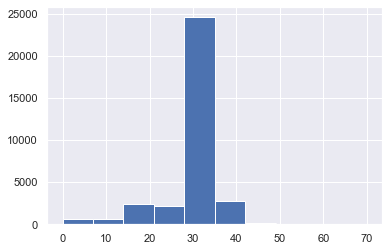

In [13]:
plt.hist(crashes['POSTED_SPEED_LIMIT'])

In [14]:
crashes.groupby(['CRASH_HOUR']).size()

CRASH_HOUR
0      689
1      580
2      518
3      439
4      376
5      475
6      779
7     1541
8     1788
9     1609
10    1504
11    1708
12    2017
13    2053
14    2261
15    2421
16    2479
17    2520
18    1996
19    1533
20    1190
21    1085
22     990
23     857
dtype: int64

(array([1787.,  815., 1254., 4938., 3212., 4070., 7161., 4516., 2723.,
        2932.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

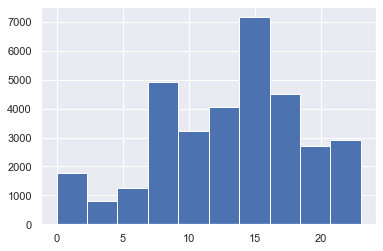

In [15]:
plt.hist(crashes['CRASH_HOUR'])

In [16]:
new_crashes = crashes.loc[(crashes['CRASH_YEAR'] == 2018)]
new_crashes
# new_crashes = crashes.loc[(df['YEAR'] == '2018') & (df['Type 2'] == 'Poison') & (df['HP'] > 70)]

,CRASH_RECORD_ID,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,HIT_AND_RUN_I,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_YEAR
1,02e2ed3606a50dda185f5e97c57a45552087d6fbea1c4b...,JB256393,2018-05-09 11:30:00,25,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,ANGLE,NOT DIVIDED,2.0,STRAIGHT AND LEVEL,WET,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,UNABLE TO DETERMINE,9511,S,WENTWORTH AVE,511,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11,4,5,41.721290,-87.628510,POINT (-87.628509593966 41.72128957001),2018
2,03def753c76d0105940f82e9eaac6f1d87683b7a574c20...,JB246843,2018-05-02 12:50:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,OTHER OBJECT,PARKING LOT,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,"OVER $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,1320,E,47TH ST,222,1,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,0.0,0.0,12,4,5,41.809781,-87.594213,POINT (-87.594212812011 41.809781151018),2018
3,14fc616db83000e28d672601062a56d76583c0889a764b...,JB372787,2018-07-31 11:25:00,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,FAILING TO YIELD RIGHT-OF-WAY,8301,S,CICERO AVE,834,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11,3,7,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989),2018
4,1a9af7862e8471daf453354e6aae4561d0ff4f2f1bfb30...,JB490362,2018-10-25 22:50:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,2.0,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,INJURY AND / OR TOW DUE TO CRASH,Y,"OVER $1,500",FAILING TO REDUCE SPEED TO AVOID CRASH,NOT APPLICABLE,2325,W,ADDISON ST,1921,1,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22,5,10,41.946644,-87.686894,POINT (-87.686894106014 41.946643528978),2018
8,29977192763df0066add561c6ea8ad1c3dcc9d399e2091...,JB261235,2018-05-12 18:00:00,30,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,REAR END,NOT DIVIDED,2.0,STRAIGHT AND LEVEL,WET,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,"OVER $1,500",FOLLOWING TOO CLOSELY,WEATHER,7074,N,RIDGE BLVD,2411,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,18,7,5,42.010941,-87.682754,POINT (-87.68275403105 42.010940800028),2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33378,ffdad6b0b41ebc6f76847d1dd0e1c7390e5ffeda5e8731...,JB397867,2018-08-17 17:30:00,25,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,"$501 - $1,500",NOT APPLICABLE,NOT APPLICABLE,30,N,WESTERN AVE,1222,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,17,6,8,41.882036,-87.686602,POINT (-87.686602413451 41.882036019034),2018
33380,ffdf9e2c81f61ce7942ca1c00085dee5daaf6091f06021...,JB547582,2018-12-10 14:12:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDESTRIAN,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,"$501 - $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,2400,S,KEDZIE AVE,1024,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,14,2,12,41.848050,-87.705295,POINT (-87.705294663572 41.848049568878),2018
33382,ffe0903c9f3be4616b14d65fe831b96230d7e6314a3f09...,JB475017,2018-10-14 01:00:00,25,NO CONTROLS,NO CON

CRASH_HOUR
0     228
1     190
2     195
3     147
4     137
5     181
6     275
7     625
8     682
9     588
10    521
11    591
12    711
13    727
14    787
15    859
16    929
17    885
18    704
19    557
20    412
21    379
22    335
23    307
dtype: int64

(array([ 613.,  284.,  456., 1895., 1112., 1438., 2575., 1589.,  969.,
        1021.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

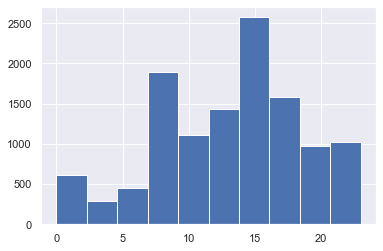

In [17]:
# crashes in 2018 displayed by CRASH_HOUR, binomial distribution, peak at 8am and 15-17
display(new_crashes.groupby(['CRASH_HOUR']).size())
plt.hist(new_crashes['CRASH_HOUR'])

CRASH_HOUR
0      58
1      31
2      40
3      37
4      36
5      47
6      78
7     157
8     165
9     151
10    151
11    153
12    166
13    159
14    194
15    204
16    196
17    231
18    168
19    141
20     92
21     83
22     67
23     51
dtype: int64

(array([ 613.,  284.,  456., 1895., 1112., 1438., 2575., 1589.,  969.,
        1021.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

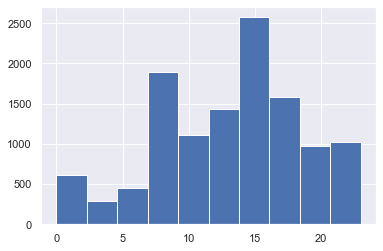

In [19]:
# crashes in 2017 displayed by CRASH_HOUR. binomial distribution, peak at 8am and 15-17
crashes_2017 = crashes.loc[(crashes['CRASH_YEAR'] == 2017)]
display(crashes_2017.groupby(['CRASH_HOUR']).size())
plt.hist(new_crashes['CRASH_HOUR'])

### Missing Value treatment suggestion

- RD_NO : 387 missing values which means crashes in 2020. fillin(0)
- LANE_CNT : 22412 missing values. suggest fillin = mode = 2
- REPORT_TYPE : 935 missing values. suggest fillin = NOT ON SCENE (DESK REPORT)
- MOST_SEVERE_INJURY : 85 missing values. suggest fillin = mode = NO INDICATION OF INJURY
- INJURIES_TOTAL : 84 missing values. suggest fillin = 0 or delete it
- INJURIES_FATAL : 84 missing values. suggest fillin = 0 or delete it
- INJURIES_INCAPACITATING : 84 missing values. suggest fillin = 0 or delete it
- INJURIES_NON_INCAPACITATING : 84 missing values. suggest fillin = 0 or delete it
- INJURIES_REPORTED_NOT_EVIDENT : 84 missing values. suggest fillin = 0 or delete it
- INJURIES_NO_INDICATION : 84 missing values. suggest fillin = 1 or delete it
- LATITUDE, LONGITUDE, 198 missing values, suggest fillin=0

### Outlier treatment

#### LANE_CNT column
- Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection)
- Outlier suspection : LANE_CNT > 10
- Treatment suggestion : FILL in all columns > 10 , (10)

In [ ]:
# the outlier at LANE_CNT column
display(crashes.groupby(['LANE_CNT']).size())
crashes.loc[crashes['LANE_CNT'] == 99]

### Target Feature

- POSTED_SPEED_LIMIT
- TRAFFIC_CONTROL_DEVICE
- DEVICE_CONDITION
- WEATHER_CONDITION
- LIGHTING_CONDITION
- FIRST_CRASH_TYPE
- TRAFFICWAY_TYPE
- CRASH_TYPE
- PRIM_CONTRIBUTORY_CAUSE
- SEC_CONTRIBUTORY_CAUSE
- NUM_UNITS
- MOST_SEVERE_INJURY

## People dataset

In [20]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82049 entries, 0 to 82048
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PERSON_ID              82049 non-null  object        
 1   PERSON_TYPE            82049 non-null  object        
 2   CRASH_RECORD_ID        82049 non-null  object        
 3   RD_NO                  73689 non-null  object        
 4   VEHICLE_ID             80306 non-null  float64       
 5   CRASH_DATE             82049 non-null  datetime64[ns]
 6   SEAT_NO                17214 non-null  float64       
 7   CITY                   60863 non-null  object        
 8   STATE                  61749 non-null  object        
 9   ZIPCODE                55588 non-null  object        
 10  SEX                    80776 non-null  object        
 11  AGE                    59254 non-null  float64       
 12  DRIVERS_LICENSE_STATE  48594 non-null  object        
 13  D

### Confirm & Modify data type
- Change VEHICLE_ID from int64 into category
    - The corresponding CRASH_UNIT_ID from the Vehicles dataset.
    source : https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d

In [3]:
pd.set_option('display.max_rows', 500)

In [4]:
people.groupby(['CITY']).count()
# crashes.groupby(['STREET_NAME']).count().sort_values('CRASH_RECORD_ID', ascending=False)

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,RD_NO,VEHICLE_ID,CRASH_DATE,SEAT_NO,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
CITY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
60630,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0
60641,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0
60643,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0
99,16,16,16,16,16,16,4,4,0,16,0,0,1,16,16,16,16,16,16,4,12,12,12,0,0,0,12,0,0
ADDISON,84,84,84,78,82,84,8,81,81,83,76,68,58,84,82,83,84,14,9,0,76,76,76,2,2,2,76,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUBA CITY,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,1,0,0
ZEELAND,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0
ZHANGJIAXU TOWN,1,1,1,1,1,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0


In [6]:
display(people.groupby(['CITY']).size())
# 16 rows with "99" => change into UNKNOWN
people(loc[people['CITY'] == '99'])
# display(crashes.groupby(['BEAT_OF_OCCURRENCE']).count().sort_values('CRASH_RECORD_ID', ascending=False))
# 1 row with 'CHICAGO => change into CHICAGO
# 1 row 60630 => change into CHICAGO
# 1 row 60641 => change into CHICAGO
# 1 row 60643 => change into CHICAGO

CITY
60630               1
60641               1
60643               1
99                 16
ADDISON            84
                   ..
YUBA CITY           1
ZEELAND             1
ZHANGJIAXU TOWN     1
ZION               26
`CHICAGO            1
Length: 2099, dtype: int64

NameError: name 'loc' is not defined

### Drop columns of people

- datetime64(ns)(1), float64(4), object(25)
- DRIVERS_LICENSE_CLASS : Mostly are class 4, license state might have more info than this
- BAC_RESULT VALUE : 99.8% missing value, hard to get info can for our analysis
- CELL_PHONE_USE : 99.92% missing value, hard to get info can for our analysis
- 

In [10]:
people.groupby(['STATE']).size()

STATE
AK        2
AL       23
AR       25
AZ       47
CA       97
CO       38
CT        6
DC        3
DE        3
FL      145
GA       70
HI        1
IA       83
ID       12
IL    58365
IN      952
KS       27
KY       24
LA       23
MA       26
MD       23
ME        1
MI      214
MN       81
MO       84
MS       30
MT        1
NB       19
NC       37
ND        8
NH        9
NJ       21
NM        3
NV       17
NY       65
OH      114
OK       20
OR        7
PA       31
RI        3
SC       14
SD        5
TN       47
TX      122
UT        6
VA       29
VT        2
WA       43
WI      271
WV        4
WY        4
XX      442
dtype: int64

### Missing value treatment suggestion

- RD_ID : 8360 missing values, means it's 2020 crashes, fillna(0)
- CITY : 21186 missing values, fillna("CHICAGO")
    - 16 rows with "99" => change into CHICAGO
    - 1 row with 'CHICAGO => change into CHICAGO
    - 1 row 60630 => change into CHICAGO
    - 1 row 60641 => change into CHICAGO
    - 1 row 60643 => change into CHICAGO
    - 21186 missing rows => filli ("CHICAGO")
- STATE : 20300 missing values, fillna("IL")
- ZIPCODE : 26461 missing values, fillna("UNKNOWN")
- SEX : 1273 missing values, fillna("X")
- AGE : 22795 missing values, fillna(mean=37.8 or median/50% percentile : 35)
- DRIVERS_LICENSE_STATE : 33455 missing values, fillna("IL") as mode
- DRIVERS_LICENSE_CLASS : 41798 missing values, fillna("D") as mode => suggest to drop
- SAFETY_EQUIPMENT : 257 missing values, fillna("USAGE UNKNOWN")
- AIRBAG_DEPLOYED : 1675 missing values, fillna("DEPLOYMENT UNKNOWN")
- EJECTION : 1094 missing values, fillna("UNKNOWN")
- INJURY_CLASSIFICATION : 50 missing values, fillna("NO INDICATION OF INJURY") as mode
- 

In [20]:
# ZIPCODE column
display(pd.set_option('display.max_rows', 2300)) #2239 distinct values
people.groupby(['ZIPCODE']).size()
# 3 row "NDA" => change into "UNKNOWN"
# 1 row of "IL" => change into "UNKNOWN"
# 8 row of "UNK" => change into "UNKNOWN"
# 1 row of \ => change into "UNKNOWN"
# existing 6 row of "UNKNOWN"

None

ZIPCODE
00000            1
01267            1
01742            1
01757            1
01944            1
01960            1
02043            1
02118            1
02124            1
02130            1
02138            1
02148            1
02151            1
02176            1
02215            1
02452            2
02467-3800       1
02557            1
02638            1
02648            2
02740            1
02840            1
02860            1
02861            1
03045            1
03060            1
03079            1
03103            1
03104            1
03766            1
03820            1
03833            1
03845            1
03873            1
04005            1
05088            1
06028            1
06042            2
06226            1
0641             1
06451            1
06492            1
06770            1
07003            1
07008            1
07022            1
07040            1
07042            1
07071            1
07206            1
07424-3332       1
07650            2
0774

In [21]:
# SEX column
people.groupby(['SEX']).size()

SEX
F    30946
M    43002
X     6828
dtype: int64

In [22]:
people['SEX']

0        M
1        F
2        X
3        F
4        M
        ..
82044    M
82045    F
82046    F
82047    M
82048    M
Name: SEX, Length: 82049, dtype: object

In [26]:
people.groupby(['AGE']).size()

AGE
0.0       716
1.0       217
2.0       201
3.0       165
4.0       178
5.0       180
6.0       187
7.0       199
8.0       182
9.0       173
10.0      172
11.0      191
12.0      183
13.0      190
14.0      226
15.0      220
16.0      327
17.0      606
18.0      962
19.0      947
20.0     1167
21.0     1345
22.0     1378
23.0     1536
24.0     1656
25.0     1709
26.0     1674
27.0     1680
28.0     1598
29.0     1631
30.0     1485
31.0     1419
32.0     1293
33.0     1336
34.0     1235
35.0     1240
36.0     1197
37.0     1090
38.0     1153
39.0     1178
40.0     1057
41.0     1030
42.0     1007
43.0      941
44.0      901
45.0      902
46.0      941
47.0      944
48.0      920
49.0      917
50.0      855
51.0      842
52.0      855
53.0      857
54.0      835
55.0      769
56.0      717
57.0      755
58.0      726
59.0      733
60.0      681
61.0      622
62.0      606
63.0      554
64.0      539
65.0      459
66.0      421
67.0      351
68.0      366
69.0      331
70.0      299
71

In [27]:
people.describe()

,VEHICLE_ID,SEAT_NO,AGE,BAC_RESULT VALUE
count,80306.000000,17214.000000,59254.000000,134.000000
mean,602088.561652,4.193099,37.805633,0.169328
std,214429.123290,2.235407,17.150075,0.087447
min,224185.000000,1.000000,0.000000,0.000000
25%,414668.250000,3.000000,25.000000,0.120000
50%,606222.500000,3.000000,35.000000,0.170000
75%,795201.000000,6.000000,50.000000,0.210000
max,920208.000000,12.000000,110.000000,0.440000


In [28]:
people.groupby(['DRIVERS_LICENSE_STATE']).size()

DRIVERS_LICENSE_STATE
AA        1
AK        3
AL       19
AN        1
AR       27
AS        1
AZ       51
B1        1
BC        2
BO        1
CA      102
CO       40
CT        8
CU        2
DC        3
DE        4
DO        1
EL        1
EN        1
EU        1
FD        1
FL      155
FN        1
GA       79
GC        1
GR        3
GU        1
HI        3
HK        1
HL        1
IA       72
ID        1
IE        1
II        4
IL    44705
IN      815
JM        1
JO        1
KN        1
KS       22
KU        2
KY       25
KZ        1
LA       18
LH        1
MA       25
MB        2
MC        1
MD       28
ME        3
MI      199
MM       13
MN       62
MO       78
MS       31
MT        2
NB       18
NC       35
ND        6
NG        5
NH        7
NJ       22
NL        1
NM        5
NV       19
NY       70
OH      113
OK       20
ON       14
OR        5
PA       37
PB        1
PM        1
PO        3
PQ        2
PR        7
RA        1
RC        3
RF        1
RI        5
SC       11
SD    

In [29]:
people.groupby(['DRIVERS_LICENSE_CLASS']).size() #class "D" has 36251
# 1 row of "\D" => change into "D" 
# 1 row of `D   => change into "D" 

DRIVERS_LICENSE_CLASS
0        13
1         2
10        3
1F        1
2         3
3         3
5         2
9        13
99        6
?         1
??        1
A      1496
A*        5
A2        1
AB        9
AD        2
AM      179
B      1168
B*        4
BE        1
BL        1
BM      104
C      1160
C*        1
CA       22
CD      117
CL       10
CM       32
CN        1
CO        2
D     36251
D*       16
D.        1
D1        1
DA        5
DD        3
DL       46
DM      717
DQ        2
DU        3
D`        3
E        80
EC        1
EO        2
F        48
G         8
G2        1
H         2
ID        3
IL        5
IP        1
J         2
L         4
LP        1
M        32
M1        1
N         5
NO        4
NP        1
NT        2
O        65
OA        1
OR        1
P         9
PS        1
R        25
S        20
SU        1
T         1
TM        3
TV       20
TX        1
U         6
UK        6
UN       21
WI        1
\D        1
`D        1
dtype: int64

In [3]:
people.groupby(['EJECTION']).size()

EJECTION
NONE                  76380
PARTIALLY EJECTED        62
TOTALLY EJECTED         289
TRAPPED/EXTRICATED       40
UNKNOWN                4184
dtype: int64

### Outlier treatment

### Target Feature
- PERSON_TYPE
- SEX
- SAFETY_EQUIPMENT
- AIRBAG_DEPLOYED
- EJECTION

#### PERSON_TYPE

In [33]:
people.groupby(['PERSON_TYPE']).size()

PERSON_TYPE
BICYCLE                  593
DRIVER                 63122
NON-CONTACT VEHICLE       16
NON-MOTOR VEHICLE         79
PASSENGER              17214
PEDESTRIAN              1025
dtype: int64

In [6]:
def PERSON (x):
    if ("DRIVER" in x):
        return "DRIVER"
    else:
        if ("PASSENGER" in x):
            return "PASSENGER"
    return "OTHER"

In [11]:
# a new column "PERSON" from PERSON_TYPE, group into DRIVER, PASSENGER, OTHER
people["PERSON"] = people["PERSON_TYPE"].apply(lambda x : PERSON(x))
people.groupby(['PERSON']).size()

PERSON
DRIVER       63122
OTHER         1713
PASSENGER    17214
dtype: int64

In [34]:
people.groupby(['SEX']).size()

SEX
F    30946
M    43002
X     6828
dtype: int64

In [31]:
people.groupby(['SAFETY_EQUIPMENT']).size()

SAFETY_EQUIPMENT
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)      130
BOOSTER SEAT                                     37
CHILD RESTRAINT - FORWARD FACING                198
CHILD RESTRAINT - REAR FACING                    80
CHILD RESTRAINT - TYPE UNKNOWN                   85
CHILD RESTRAINT NOT USED                         40
CHILD RESTRAINT USED                            516
CHILD RESTRAINT USED IMPROPERLY                  13
DOT COMPLIANT MOTORCYCLE HELMET                  61
HELMET NOT USED                                 361
HELMET USED                                      80
NONE PRESENT                                   2660
NOT DOT COMPLIANT MOTORCYCLE HELMET               7
SAFETY BELT NOT USED                            502
SAFETY BELT USED                              40251
SHOULD/LAP BELT USED IMPROPERLY                   8
STRETCHER                                         2
USAGE UNKNOWN                                 36753
WHEELCHAIR                                     

In [32]:
people.groupby(['AIRBAG_DEPLOYED']).size()

AIRBAG_DEPLOYED
DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)       38
DEPLOYED, COMBINATION                      1791
DEPLOYED, FRONT                            2837
DEPLOYED, SIDE                              691
DEPLOYMENT UNKNOWN                        15177
DID NOT DEPLOY                            46436
NOT APPLICABLE                            13404
dtype: int64

In [4]:
people.groupby(['EJECTION']).size()

EJECTION
NONE                  76380
PARTIALLY EJECTED        62
TOTALLY EJECTED         289
TRAPPED/EXTRICATED       40
UNKNOWN                4184
dtype: int64

In [5]:
people.groupby(['INJURY_CLASSIFICATION']).size()

INJURY_CLASSIFICATION
FATAL                          41
INCAPACITATING INJURY         823
NO INDICATION OF INJURY     74612
NONINCAPACITATING INJURY     4189
REPORTED, NOT EVIDENT        2334
dtype: int64

## Vehicles dataset

In [12]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75673 entries, 0 to 75672
Data columns (total 72 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   CRASH_UNIT_ID             75673 non-null  int64         
 1   CRASH_RECORD_ID           75673 non-null  object        
 2   RD_NO                     67544 non-null  object        
 3   CRASH_DATE                75673 non-null  datetime64[ns]
 4   UNIT_NO                   75673 non-null  int64         
 5   UNIT_TYPE                 75561 non-null  object        
 6   NUM_PASSENGERS            11633 non-null  float64       
 7   VEHICLE_ID                73804 non-null  float64       
 8   CMRC_VEH_I                1514 non-null   object        
 9   MAKE                      73804 non-null  object        
 10  MODEL                     73787 non-null  object        
 11  LIC_PLATE_STATE           67639 non-null  object        
 12  VEHICLE_YEAR      

In [14]:
vehicles.groupby(['VEHICLE_TYPE']).size()

VEHICLE_TYPE
3-WHEELED MOTORCYCLE (2 REAR WHEELS)          3
ALL-TERRAIN VEHICLE (ATV)                     9
AUTOCYCLE                                    24
BUS OVER 15 PASS.                           884
BUS UP TO 15 PASS.                          146
FARM EQUIPMENT                                7
MOPED OR MOTORIZED BICYCLE                   13
MOTOR DRIVEN CYCLE                           24
MOTORCYCLE (OVER 150CC)                     185
OTHER                                       814
OTHER VEHICLE WITH TRAILER                  106
PASSENGER                                 46978
PICKUP                                     2263
RECREATIONAL OFF-HIGHWAY VEHICLE (ROV)        1
SINGLE UNIT TRUCK WITH TRAILER              113
SNOWMOBILE                                    1
SPORT UTILITY VEHICLE (SUV)                9460
TRACTOR W/ SEMI-TRAILER                     774
TRACTOR W/O SEMI-TRAILER                    110
TRUCK - SINGLE UNIT                        1498
UNKNOWN/NA                 

In [19]:
pd.set_option('display.max_rows', 400)
vehicles.groupby(['MAKE']).size()

MAKE
"(ASSEMBLED FROM PARTS, HOMEMADE)"                                 1
"ALLISON'S FIBERGLASS MFG., INC (PORT ORANGE., FLORIDA)."          1
"CLASSIC MOTOR CARRIAGES, INC. (HALLANDALE, FLORIDA)"              3
(HOMEMADE MOTORCYCLE, MOPED.ETC.)                                  6
(UNLISTED CONSTRUCTION EQUIPMENT MAKE)                             1
(UNLISTED MAKE)                                                    5
A-1 TRAILER                                                        4
A-A WELDING SERVICE                                                1
A.J. TRAVELUTE TRAILER MANUFACTURING COMPANY                       1
ACURA                                                            708
ACURA (DIV. OF AMERICAN HONDA MOTOR CO.)                         172
ACURA SLX (SPORTS UTILITY)                                         4
ALEXANDER-REYNOLDS CORP.                                           2
ALFA ROMEO                                                         5
ALL TERRAIN - TRACKS AND WHEE

In [22]:
pd.set_option('display.max_rows', 500)
vehicles.groupby(['MODEL']).size()

MODEL
"(ASSEMBLED FROM PARTS, HOMEMADE)"                            1
"ALLISON'S FIBERGLASS MFG., INC (PORT ORANGE., FLORIDA)."     1
"CLASSIC MOTOR CARRIAGES, INC. (HALLANDALE, FLORIDA)"         3
"E" TYPE                                                      4
(HOMEMADE MOTORCYCLE, MOPED.ETC.)                             6
                                                             ..
Z3                                                            5
ZDX                                                          48
ZEPHYR                                                        3
ZIM                                                           1
ZX2                                                           3
Length: 1256, dtype: int64

In [18]:
vehicles.groupby(['VEHICLE_TYPE']).size()

VEHICLE_TYPE
3-WHEELED MOTORCYCLE (2 REAR WHEELS)          3
ALL-TERRAIN VEHICLE (ATV)                     9
AUTOCYCLE                                    24
BUS OVER 15 PASS.                           884
BUS UP TO 15 PASS.                          146
FARM EQUIPMENT                                7
MOPED OR MOTORIZED BICYCLE                   13
MOTOR DRIVEN CYCLE                           24
MOTORCYCLE (OVER 150CC)                     185
OTHER                                       814
OTHER VEHICLE WITH TRAILER                  106
PASSENGER                                 46978
PICKUP                                     2263
RECREATIONAL OFF-HIGHWAY VEHICLE (ROV)        1
SINGLE UNIT TRUCK WITH TRAILER              113
SNOWMOBILE                                    1
SPORT UTILITY VEHICLE (SUV)                9460
TRACTOR W/ SEMI-TRAILER                     774
TRACTOR W/O SEMI-TRAILER                    110
TRUCK - SINGLE UNIT                        1498
UNKNOWN/NA                 

In [ ]:
# split the data into train and test by 80/20
# train_size = int(len(data) * .8)
# print ("Train size %d" % train_size)
# print ("Test size %d" % (len(data) - train_size))

In [ ]:
# Create bag of words matrices 
# from preprocess import Textpreprocessor
# train_qs = data['text'].value[:train_size]
# test_qs = data['text'].value[train_size:]

# VOCAB_SIZE = 400
# preprocessor = TextPreprocessor(VOCAB_SIZE)
# preprocessor.create_tokenizer(train_qs)

# body_train = preprocessor.transform_text(train_qs)
# body_test = processor.transform_text(test.qs)

In [ ]:
# Preview training data
# print(len(body_train[0]))
# print(body_train[0])